In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install lazypredict
!pip install pyswarms


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

train_features = pd.read_csv('train_features.csv')
train_features.head()

,facilities,rating,location
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol


In [3]:
print('Train feature dataframe shape:', train_features.shape)

Train feature dataframe shape: (3066, 3)


In [4]:
test_features = pd.read_csv('test_feature.csv')
test_features.head()

,ID,facilities,rating,location
0,0,GymrestaurantbarInternetSwimmingPools,8.0 ExcellentFrom 1 reviews,Stokol
1,1,Poolrestaurantgyminternetbar,7.4 Very GoodFrom 22 reviews,Hallerson
2,2,BARSwimmingPoolsInternetgym,0.0 FairFrom 4 reviews,Hallerson
3,3,gymSwimmingPoolsBARintrnetRestaurant,6.8 Very GoodFrom 13 reviews,Andeman
4,4,gymRestaurantpoolbarintrnet,0.0 FairFrom 9 reviews,Hallerson


In [5]:
test = test_features.drop(['ID'], axis=1)
test.head()

,facilities,rating,location
0,GymrestaurantbarInternetSwimmingPools,8.0 ExcellentFrom 1 reviews,Stokol
1,Poolrestaurantgyminternetbar,7.4 Very GoodFrom 22 reviews,Hallerson
2,BARSwimmingPoolsInternetgym,0.0 FairFrom 4 reviews,Hallerson
3,gymSwimmingPoolsBARintrnetRestaurant,6.8 Very GoodFrom 13 reviews,Andeman
4,gymRestaurantpoolbarintrnet,0.0 FairFrom 9 reviews,Hallerson


In [6]:
print('Test feature dataframe shape:', test.shape)

Test feature dataframe shape: (767, 3)


In [7]:
combine = pd.concat([train_features, test])
combine.head()

,facilities,rating,location
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol


In [8]:
print('Combined feature dataframe shape:', combine.shape)

Combined feature dataframe shape: (3833, 3)


In [9]:
combine.isnull().sum()

facilities    301
rating        637
location        0
dtype: int64

In [10]:
combine['facilities'] = combine['facilities'].str.lower()
combine.head()

,facilities,rating,location
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,Wanderland
3,barrestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,Stokol


In [11]:
combine['facilities'].fillna('missing_facilities', inplace=True)
combine['rating'].fillna('missing_rating', inplace=True)

In [12]:
# Create a new column for each facility
facilities = ['restaurant', 'bar', 'swimmingpools', 'internet', 'gym', 'intrnet', 'missing_facilities']
for facility in facilities:
    combine[facility] = np.where(combine['facilities'].str.contains(facility), 1, 0)
combine.head()

,facilities,rating,location,restaurant,bar,swimmingpools,internet,gym,intrnet,missing_facilities
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,Stokol,1,1,1,0,0,0,0
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,1,0,0,0,1,1,0
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,Wanderland,1,1,0,0,1,0,0
3,barrestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,1,1,0,0,0,0,0
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,Stokol,1,0,0,1,0,0,0


In [13]:
def extract_avg_rating(text):
    if len(text.split()) > 3:
        return np.float32(text.split()[0])
    return 0

In [14]:
combine['avg_rating'] = combine['rating'].apply(extract_avg_rating)
combine['avg_rating'] = combine['avg_rating'].astype(np.float32)
combine.head()

,facilities,rating,location,restaurant,bar,swimmingpools,internet,gym,intrnet,missing_facilities,avg_rating
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,Stokol,1,1,1,0,0,0,0,7.8
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,1,0,0,0,1,1,0,5.6
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,Wanderland,1,1,0,0,1,0,0,7.2
3,barrestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,1,1,0,0,0,0,0,7.3
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,Stokol,1,0,0,1,0,0,0,7.2


In [15]:
def extract_total_rating(text):
    if len(text.split()) >=2:
        return np.float32(text.split()[-2])
    return 0

In [16]:
combine['total_rating'] = combine['rating'].apply(extract_total_rating)
combine['total_rating'] = combine['total_rating'].astype(np.float32)
combine.head()

,facilities,rating,location,restaurant,bar,swimmingpools,internet,gym,intrnet,missing_facilities,avg_rating,total_rating
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,Stokol,1,1,1,0,0,0,0,7.8,10.0
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,1,0,0,0,1,1,0,5.6,4.0
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,Wanderland,1,1,0,0,1,0,0,7.2,38.0
3,barrestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,1,1,0,0,0,0,0,7.3,6.0
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,Stokol,1,0,0,1,0,0,0,7.2,30.0


In [17]:
def extract_rating(text):
    ratings = {
    'very good': 3,
    'fair': 1,
    'good': 2,
    'excellent': 4
    }
    for k, v in ratings.items():
        if k.lower() in text.lower():
            return ratings[k]
    return 1

combine['rating_encode'] = combine['rating'].apply(extract_rating)
combine.head()

,facilities,rating,location,restaurant,bar,swimmingpools,internet,gym,intrnet,missing_facilities,avg_rating,total_rating,rating_encode
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,Stokol,1,1,1,0,0,0,0,7.8,10.0,3
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,1,0,0,0,1,1,0,5.6,4.0,2
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,Wanderland,1,1,0,0,1,0,0,7.2,38.0,3
3,barrestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,1,1,0,0,0,0,0,7.3,6.0,3
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,Stokol,1,0,0,1,0,0,0,7.2,30.0,3


In [18]:
combine['internet'] = combine['internet'] + combine['intrnet']
combine = combine.drop(['intrnet'], axis=1)
combine.head()

,facilities,rating,location,restaurant,bar,swimmingpools,internet,gym,missing_facilities,avg_rating,total_rating,rating_encode
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,Stokol,1,1,1,0,0,0,7.8,10.0,3
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,1,0,0,1,1,0,5.6,4.0,2
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,Wanderland,1,1,0,0,1,0,7.2,38.0,3
3,barrestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,1,1,0,0,0,0,7.3,6.0,3
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,Stokol,1,0,0,1,0,0,7.2,30.0,3


# Exploratory Data Analysis

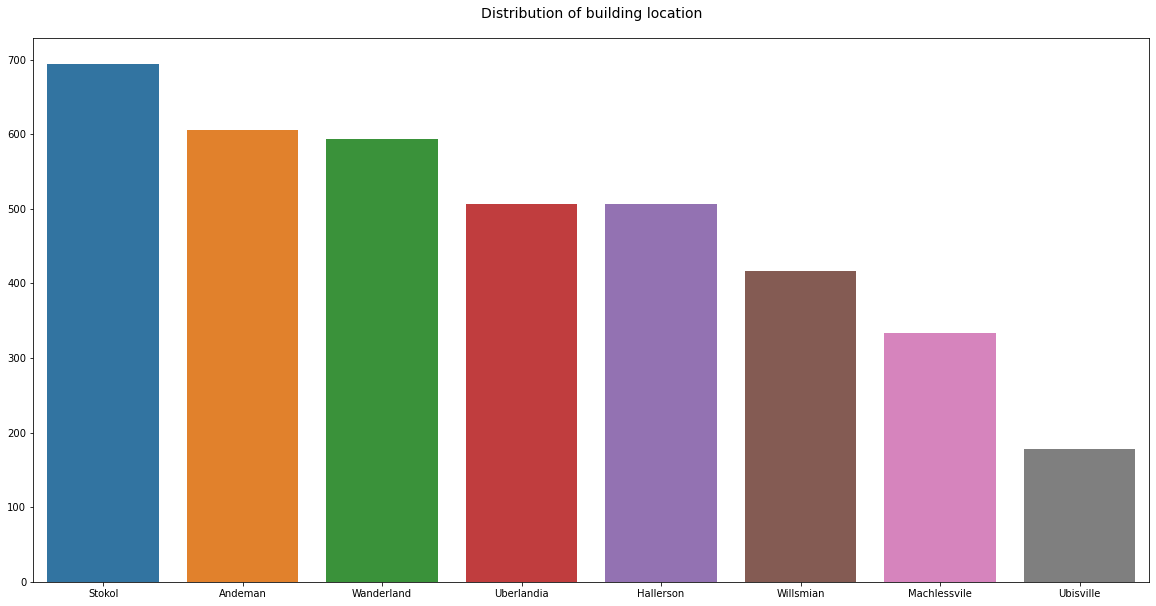

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)

locations = combine['location'].value_counts()
sns.barplot(x=locations.index, y=locations.values)
plt.title('Distribution of building location', fontsize=14, pad=20)
plt.show()

In [20]:
facitilites = pd.DataFrame({
    'facilities': combine.columns[3:9],
    'counts': [np.sum(combine[col]) for col in combine.columns[3:9]]
}).sort_values('counts', ascending=False)

facitilites

,facilities,counts
0,restaurant,3063
1,bar,2948
3,internet,2064
4,gym,1430
2,swimmingpools,884
5,missing_facilities,301


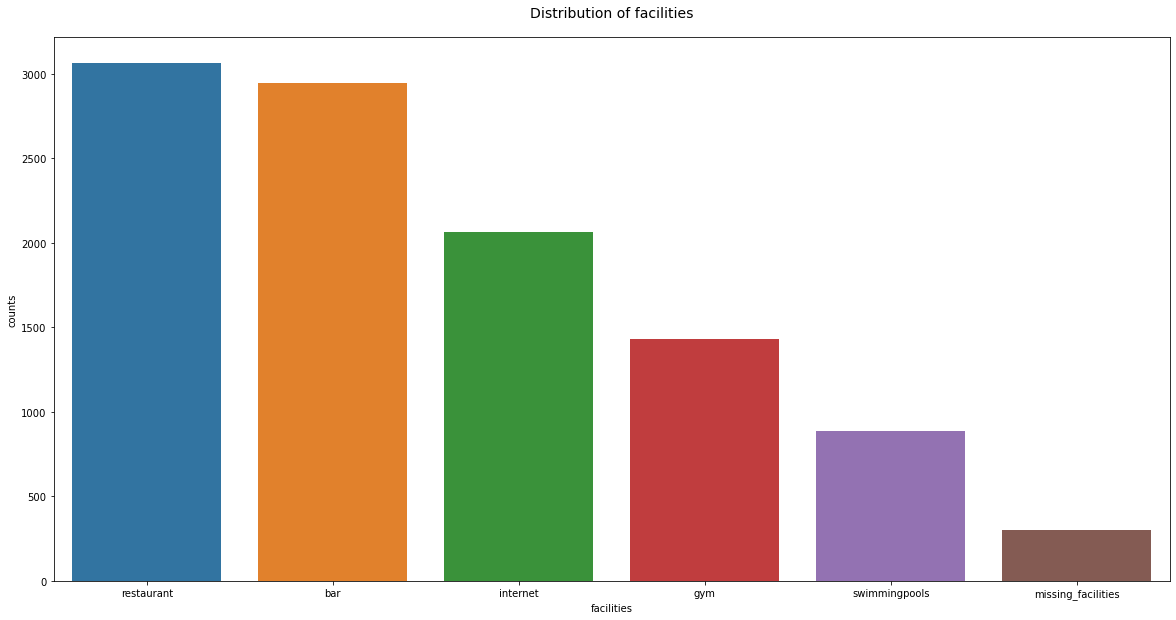

In [21]:
sns.barplot(data=facitilites, x='facilities', y='counts')
plt.title('Distribution of facilities', fontsize=14, pad=20)
plt.show()

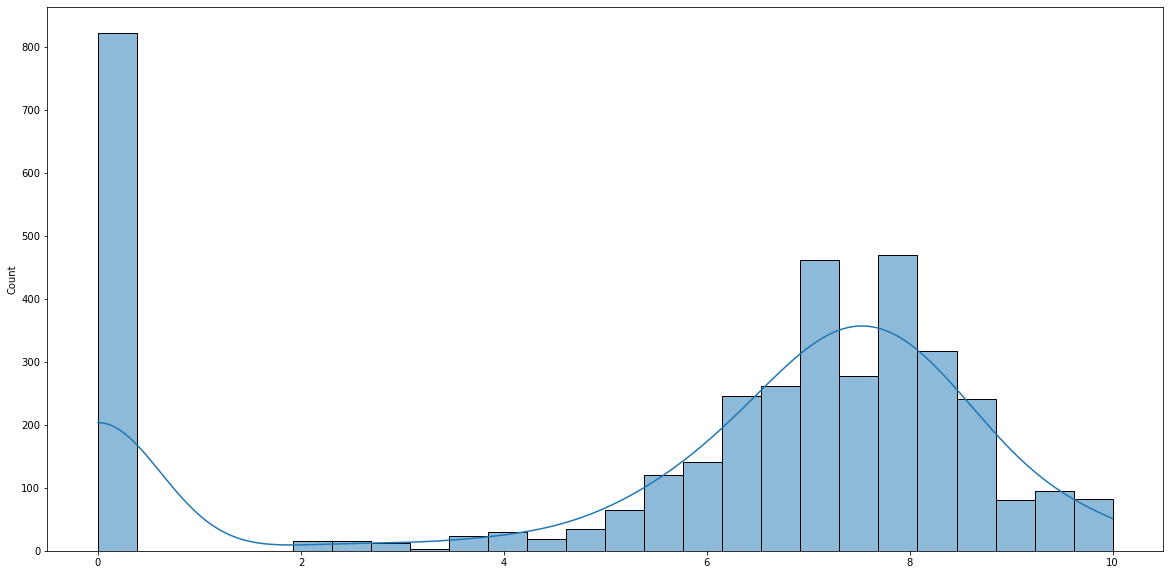

In [22]:
avg_rating = combine['avg_rating'].values
sns.histplot(x=avg_rating, kde=True)
plt.show()

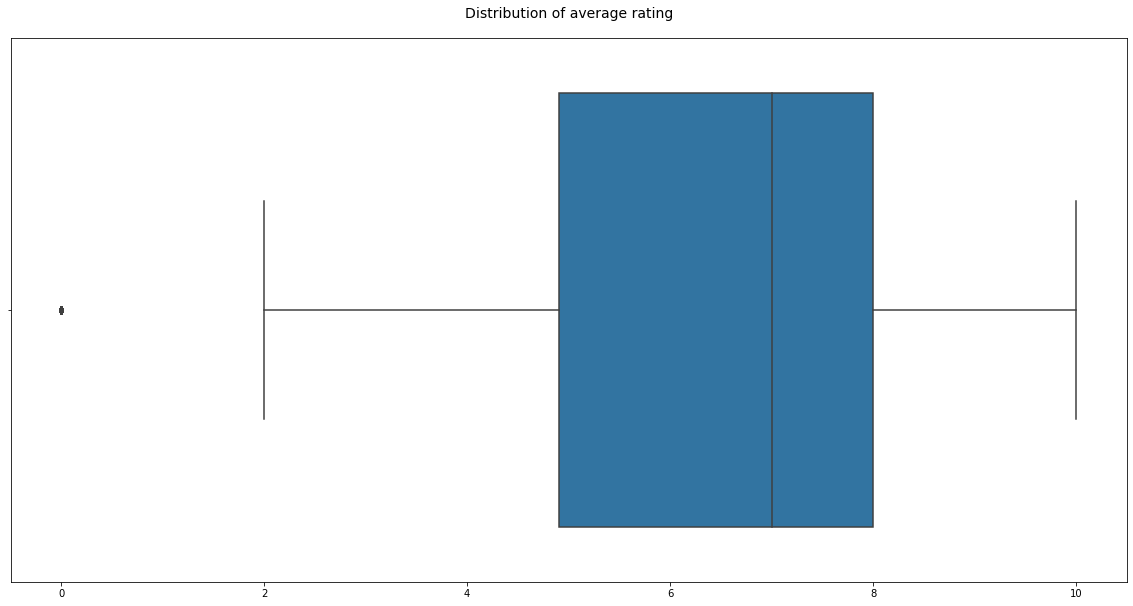

In [23]:
sns.boxplot(x=avg_rating)
plt.title('Distribution of average rating', fontsize=14, pad=20)
plt.show()

In [24]:
rating = pd.DataFrame({
    'rating': combine.columns[-5:],
    'counts': [np.sum(combine[col]) for col in combine.columns[-5:]]
}).sort_values('counts', ascending=False)

rating

,rating,counts
3,total_rating,54533.000000
2,avg_rating,21970.599609
4,rating_encode,10350.000000
0,gym,1430.000000
1,missing_facilities,301.000000


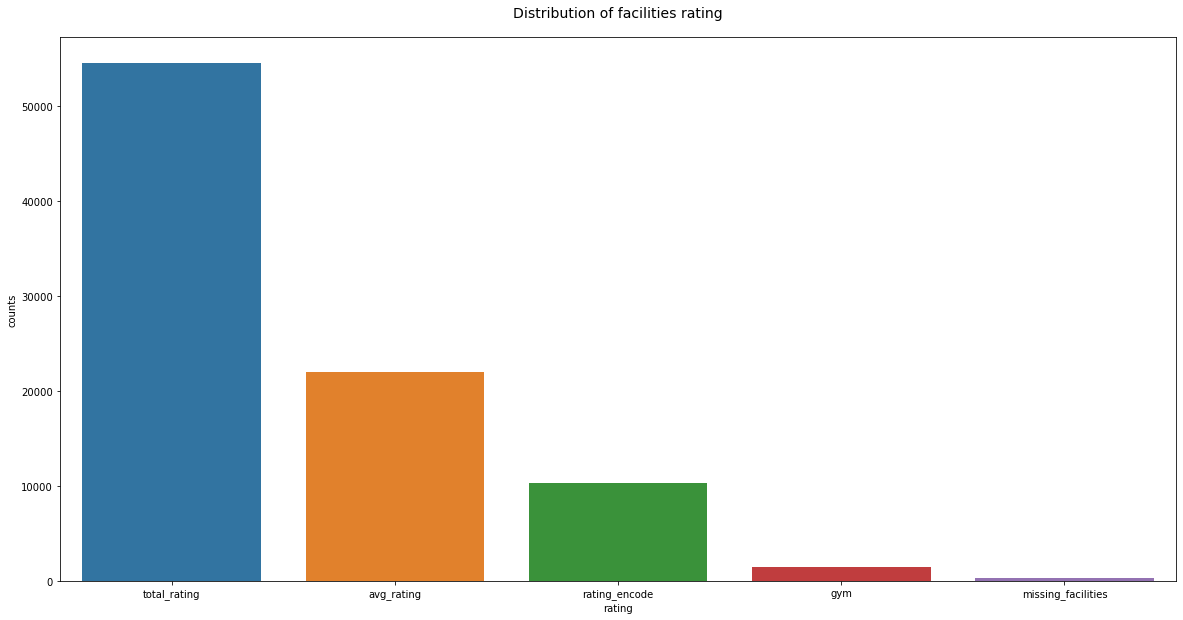

In [25]:
sns.barplot(data=rating, x='rating', y='counts')
plt.title('Distribution of facilities rating', fontsize=14, pad=20)
plt.show()

In [26]:
combine = pd.get_dummies(combine, columns=['location'])
combine.head()

,facilities,rating,restaurant,bar,swimmingpools,internet,gym,missing_facilities,avg_rating,total_rating,rating_encode,location_Andeman,location_Hallerson,location_Machlessvile,location_Stokol,location_Uberlandia,location_Ubisville,location_Wanderland,location_Willsmian
0,restaurantbarswimmingpools,7.8 Very GoodFrom 10 reviews,1,1,1,0,0,0,7.8,10.0,3,0,0,0,1,0,0,0,0
1,intrnetrestaurantgym,5.6 GoodFrom 4 reviews,1,0,0,1,1,0,5.6,4.0,2,0,0,1,0,0,0,0,0
2,restaurantgympoolbar,7.2 Very GoodFrom 38 reviews,1,1,0,0,1,0,7.2,38.0,3,0,0,0,0,0,0,1,0
3,barrestaurant,7.3 Very GoodFrom 6 reviews,1,1,0,0,0,0,7.3,6.0,3,0,0,0,0,1,0,0,0
4,internetrestaurant,7.2 Very GoodFrom 30 reviews,1,0,0,1,0,0,7.2,30.0,3,0,0,0,1,0,0,0,0


In [27]:
features = [2,3,4,5,6,7,8,10,11,12,13,14,15,16,17]
X = combine.iloc[:train_features.shape[0], features]
y = pd.read_csv('train_label.csv')
y['Price'] = y['Price'].apply(lambda x: np.float32(''.join(x[:-9].split(','))))

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [29]:
print('Total X_train:', len(X_train))
print('Total X_test:', len(X_test))
print('Total y_train:', len(y_train))
print('Total y_test:', len(y_test))

Total X_train: 2146
Total X_test: 920
Total y_train: 2146
Total y_test: 920


In [30]:
from sklearn.preprocessing import MinMaxScaler

scaled_feature = ['avg_rating']
scaler = MinMaxScaler()
X_train[scaled_feature] = scaler.fit_transform(X_train[scaled_feature])
X_test[scaled_feature] = scaler.transform(X_test[scaled_feature])

In [31]:
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_absolute_error

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=mean_absolute_error)
# models, predictions = reg.fit(X_train.values, X_test.values, y_train.values, y_test.values)
# models.sort_values('mean_absolute_error', ascending=True)

In [32]:
from sklearn.tree import DecisionTreeRegressor

decision = DecisionTreeRegressor()
decision.fit(X_train.values, y_train.values)

DecisionTreeRegressor()

In [33]:
yhat = decision.predict(X_test.values)
mae = mean_absolute_error(y_test.values, yhat)
print('MAE for DecisionTreeRegressor:', mae)
print('Prediction mean for DecisionTreeRegressor:', np.mean(yhat))

MAE for DecisionTreeRegressor: 7567.005003298831
Prediction mean for DecisionTreeRegressor: 18121.088386931286


In [34]:
def decision_fitness(params):
    param = {
        'max_depth': int(params[0][0]),
        'min_samples_split': params[0][1],
        'min_samples_leaf': params[0][2],
        'max_features': params[0][3],
        'max_leaf_nodes': int(params[0][4])
    }
    
    decision = DecisionTreeRegressor(**param)
    decision.fit(X_train.values, y_train.values)
    yhat = decision.predict(X_test.values)
    mae = mean_absolute_error(y_test.values, yhat)
    return mae

In [35]:
from pyswarms.single.global_best import GlobalBestPSO

bounds = (
    np.array([0, 0.0001, 0.001, 0.0001, 2]),
    np.array([100, 1, 10, 1, 100])
)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=3, dimensions=5, options=options, bounds=bounds)
best_cost, best_params = optimizer.optimize(decision_fitness, iters=100)

print('Best parameters:', best_params)
print('Best cost:', best_cost)

2023-05-21 19:22:39,528 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|100/100, best_cost=1.16e+4
2023-05-21 19:22:39,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11629.646921471696, best pos: [29.83312391  0.89898391  6.3228121   0.70154322 66.01627437]


Best parameters: [29.83312391  0.89898391  6.3228121   0.70154322 66.01627437]
Best cost: 11629.646921471696


In [36]:
max_depth, min_samples_split, min_samples_leaf, max_features, max_leaf_nodes = best_params
decision = DecisionTreeRegressor(
    max_depth=int(max_depth),
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    max_leaf_nodes=int(max_leaf_nodes)
)
decision.fit(X_train.values, y_train.values)

DecisionTreeRegressor(max_depth=29, max_features=0.7015432203925559,
                      max_leaf_nodes=66, min_samples_leaf=6.322812096051358,
                      min_samples_split=0.8989839105718835)

In [37]:
yhat = decision.predict(X_test.values)
mae = mean_absolute_error(y_test.values, yhat)
print('MAE for DecisionTreeRegressor + PSO:', mae)
print('Prediction mean for DecisionTreeRegressor + PSO:', np.mean(yhat))

MAE for DecisionTreeRegressor + PSO: 11629.646921471696
Prediction mean for DecisionTreeRegressor + PSO: 18913.480428704566


In [38]:
new_test = combine.iloc[train_features.shape[0]:, features]
new_test[['avg_rating']] = scaler.transform(new_test[['avg_rating']])
yhat = decision.predict(new_test.values)
submission_df = pd.DataFrame({
    'ID': test_features['ID'].values,
    'Price': yhat
})

# submission_df.to_csv('submission.csv', index=False)
print('Prediction mean:', np.mean(yhat))
submission_df.head()

ValueError: Columns must be same length as key